
# Построение baseline-решений

Построим несколько простых моделей и оценим их с помощью выбранных метрик качества: AUC-PR в качестве основной метрики,
precision и recall в качестве вспомогательных.

Для начала импортируем train-set и подготовим данные для последующего обучения. Для baseline будем использовать проверенные 
и относительно простые преобразования, а также результаты анализа данных, выполненного на предыдущем этапе проекта.


In [1]:

# data manipulations
import pandas as pd
import numpy as np

# visualization
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# others
import os
import warnings
warnings.filterwarnings('ignore')

# load data
df = pd.read_csv(os.path.join('train_data', 'main_train_set.csv'))
num_features = df.columns[:190]
cat_features = df.columns[190:-1]



Прежде всего удалим из данных пустые столбцы и строки. Кроме того, заменим метку класса ``не отток`` с -1 на 0.


In [2]:

df = df.dropna(axis=0, how='all', subset=df.columns[:-1])
df = df.dropna(axis=1, how='all')
df['churn'] = df.churn.apply(lambda x: int(x > 0))

num_features = num_features.intersection(df.columns)
cat_features = cat_features.intersection(df.columns)



Посмотрим на оставшиеся вещественные признаки:


In [3]:

stats = df[num_features].describe(percentiles=[.25, .5, .75, .95]).T
display(stats)


,count,mean,std,min,25%,50%,75%,95%,max
Var1,423.0,10.269504,34.701069,0.00,0.00,0.00,16.000,32.000,536.00
Var2,728.0,0.006868,0.185312,0.00,0.00,0.00,0.000,0.000,5.00
Var3,728.0,504.144231,5203.937476,0.00,0.00,0.00,0.000,561.450,130668.00
Var4,965.0,0.121244,1.322803,0.00,0.00,0.00,0.000,0.000,27.00
Var5,879.0,228172.292378,626526.211901,0.00,0.00,0.00,106005.000,1245722.500,5100150.00
...,...,...,...,...,...,...,...,...,...
Var186,423.0,3.035461,8.494000,0.00,0.00,0.00,0.000,18.000,102.00
Var187,423.0,15.134752,54.512560,0.00,0.00,4.00,14.000,47.800,910.00
Var188,728.0,163.593791,112.355203,-6.42,19.38,195.54,252.435,317.700,524.64
Var189,12531.0,270.302610,86.545517,6.00,204.00,270.00,324.000,414.000,642.00


In [4]:

print(f"Признаков, для которых отсутствет более половины значений: {len(stats[stats['count'] / len(df) < .5])}")
print(f"Признаков, у которых по меньшей мере 95 % значений совпадают: { len(stats[stats['min'] == stats['95%']])}")


Признаков, для которых отсутствет более половины значений: 133
Признаков, у которых по меньшей мере 95 % значений совпадают: 16



Видно, что у значительной части вещественных признаков значения отсутствуют для более чем половины объектов выборки. Обработка
пропусков в этом случае может быть нетривиальной и потребует детального анализа распределения. Поэтому для простоты в качестве
baseline-решения удалим эти признаки из выборки. Кроме того, ряд вещественных признаков в первом приближении выглядит почти
константными, их для простоты мы тоже не будем рассматривать.  


In [5]:

num_features_to_drop = set(stats[stats['count'] / len(df) < .5].index.values)
num_features_to_drop |= set(stats[stats['min'] == stats['95%']].index.values)

num_features = num_features.drop(labels=num_features_to_drop)



Посмотрим теперь на корреляцию оставшихся вещественных признаков:


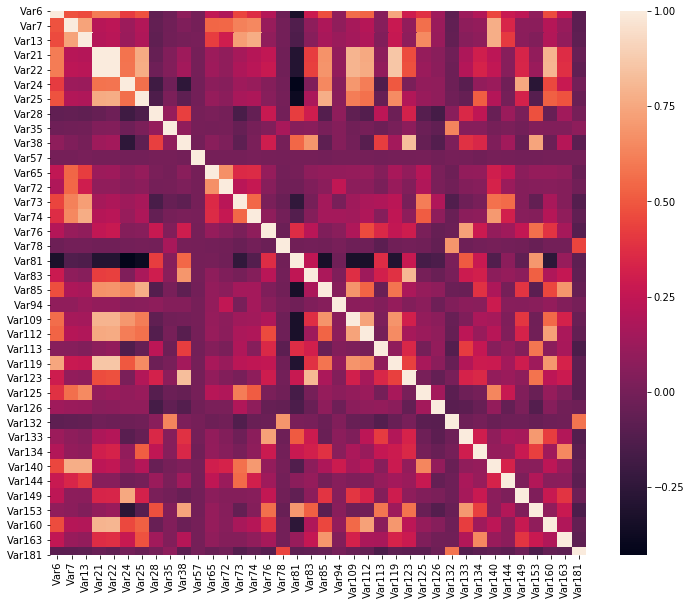

In [28]:

corr_mx = df[num_features].corr(method="spearman")
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mx)
plt.show()


In [29]:

print(f"Max positive correlation: {corr_mx.values[corr_mx.values < 1.].max()}")
print(f"Max negative correlation: {corr_mx.values[corr_mx.values > -1.].min()}")


Max positive correlation: 0.8550172445588008
Max negative correlation: -0.42777010184991493



Среди вещественных признаков есть те, корреляцию между которыми можно назвать существенной.


In [33]:

corr_mx = corr_mx.abs()
upper = corr_mx.where(np.triu(np.ones(corr_mx.shape), k=1).astype(np.bool))

num_features_to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
num_features = num_features.drop(labels=num_features_to_drop)



Теперь рассмотрим категориальные признаки.
